In [1]:
pip install openpyxl

     |████████████████████████████████| 242 kB 516 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import fasttext
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU,LSTM,Bidirectional,Dropout,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Flatten,Input
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import gensim
from tqdm import tqdm
from gensim.models import word2vec
from sklearn import metrics


### Import excel file for maghreb countries

In [3]:
df=pd.read_excel("../input/data-arabic-dialect/data_maghreb.xlsx",index_col=0,
              dtype={'tokens': str, 'dialect': str})
## check the presence of null values
df.isna().sum()

tokens     0
dialect    0
dtype: int64

In [4]:
## reset index
df=df.reset_index()
df.drop('index',axis=1,inplace=True)

### count numbers of sentences that belong to each country

Index(['LY', 'DZ', 'MA', 'TN'], dtype='object')


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='dialect'>

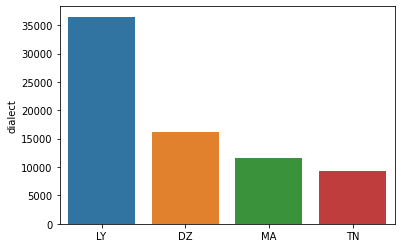

In [5]:
x=df['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

### compute the max number of words ( max_length of the sentence)

In [6]:
def splitolist(data):
    l=data.split(" ")
    return l

In [7]:
df['tokens1']=df['tokens'].apply(splitolist)

In [8]:
max_length=df.tokens1.str.len().max()
print("max length is"+" "+str(max_length))


max length is 61


In [9]:
df.loc[0,['tokens','dialect']][0]

'قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تقولي نشاط حقوق المراه رده فعلهم'

### create a corpus of the entire dataset in a txt file

In [10]:
with open(r'./corpus.txt', 'w', encoding='utf-8') as txtfile:
    for i in range(len(df)):
        line = df.loc[i,'tokens']
        txtfile.write(line)
        txtfile.write('\n')

### train skipgram model on the corpus

In [11]:
EMBED_SIZE=100
model = fasttext.train_unsupervised('./corpus.txt',
                                    minCount = 5, 
                                    model='skipgram',
                                    minn = 2,
                                    maxn = 5,
                                    dim = 100,
                                    lr = 0.1,
                                    epoch = 10)

Read 0M words
Number of words:  20193
Number of labels: 0
Progress: 100.0% words/sec/thread:   90580 lr:  0.000000 avg.loss:  1.615535 ETA:   0h 0m 0s


In [12]:
#create a list of all unique words in the dataset
with open(r'./corpus.txt', 'r', encoding="utf-8") as txtfile:
    corpus_sentences = txtfile.readlines()
    corpus_words = []
    for sent in corpus_sentences:
        tokenized_sent = sent.split()
        for word_ in tokenized_sent:
            corpus_words.append(word_)
            
    corpus_unique_words = list(set(corpus_words))

### convert text to numbers using tokenizer

In [13]:
tokenizer = Tokenizer(num_words=len(corpus_unique_words)+1)
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])

In [14]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_length,padding='post')  ## padding all the sentences in the dataset to have the same length

Found 134293 unique tokens.


### create embedding matrix from the trained fasttext model

In [15]:
vocab_size = len(tokenizer.word_index)+1
embeddings_matrix = np.zeros(shape = (vocab_size , EMBED_SIZE))

for word, index in tqdm(tokenizer.word_index.items()):
    embeddings_matrix[index] = model.get_word_vector(word)

100%|██████████| 134293/134293 [00:02<00:00, 63819.24it/s]


In [16]:
data_y=pd.get_dummies(df['dialect'])

In [17]:
data_y[:10]

,DZ,LY,MA,TN
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
5,0,1,0,0
6,0,1,0,0
7,0,1,0,0
8,0,1,0,0
9,0,1,0,0


In [26]:
#split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data,data_y, test_size = 0.1, stratify =data_y,shuffle=True)

In [27]:
#create a bidirectional LSTM model
def create_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, EMBED_SIZE, 
                                weights=[embeddings_matrix], 
                                input_length=max_length , 
                                trainable=True)
    
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(5000, activation='relu'))
    model.add(Dense(len(np.unique(df['dialect'])), activation='softmax'))
    return model

model1 = create_model()
tf.keras.backend.clear_session()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss',mode = 'max',patience=3,verbose=1) #,mode = 'min',callbacks=[early_stop]
early_stopping = EarlyStopping(monitor='loss', patience=2)
tf.keras.backend.clear_session()
# early_stopping = EarlyStopping(monitor= 'val_acc', 
#                                mode = 'max',
#                                patience=30, 
#                                verbose=1)

# model_checkpoint = ModelCheckpoint('levant_dialect_CLASSIFIER',
#                                    monitor = 'val_acc', 
#                                    mode = 'max', 
#                                    save_best_only=True, 
#                                    verbose=1)


opt = Adam(learning_rate = 0.0001)

model1.compile(opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [28]:
np.unique(df['dialect']).tolist()

['DZ', 'LY', 'MA', 'TN']

In [29]:
#train the model
history = model1.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=32,
                    epochs=50,
                    callbacks = [early_stop])

Epoch 1/50
2066/2066 [==============================] - 31s 14ms/step - loss: 0.9472 - accuracy: 0.6201 - val_loss: 0.7777 - val_accuracy: 0.7010
Epoch 2/50
2066/2066 [==============================] - 28s 13ms/step - loss: 0.7198 - accuracy: 0.7189 - val_loss: 0.6874 - val_accuracy: 0.7352
Epoch 3/50
2066/2066 [==============================] - 28s 13ms/step - loss: 0.6114 - accuracy: 0.7635 - val_loss: 0.6567 - val_accuracy: 0.7518
Epoch 4/50
2066/2066 [==============================] - 28s 14ms/step - loss: 0.5264 - accuracy: 0.7993 - val_loss: 0.6475 - val_accuracy: 0.7526
Epoch 00004: early stopping


In [30]:
model1.save("maghreb.h5")

In [31]:
target_names=np.unique(df['dialect']).tolist()
target_names

['DZ', 'LY', 'MA', 'TN']

In [32]:
y_test

,DZ,LY,MA,TN
57498,1,0,0,0
33284,0,1,0,0
50417,0,0,1,0
72018,1,0,0,0
68356,1,0,0,0
...,...,...,...,...
54492,0,0,1,0
15966,0,1,0,0
62287,1,0,0,0
63568,1,0,0,0


In [33]:
np.argmax(np.array(y_test),axis=1)

array([0, 1, 2, ..., 0, 0, 0])

### classification report for test data

In [34]:
pred=model1.predict(x_test)
print(classification_report(np.argmax(np.array(y_test),axis=1),np.argmax(pred,axis=1), target_names=target_names))

              precision    recall  f1-score   support

          DZ       0.65      0.67      0.66      1618
          LY       0.83      0.86      0.84      3648
          MA       0.79      0.64      0.71      1154
          TN       0.59      0.61      0.60       925

    accuracy                           0.75      7345
   macro avg       0.72      0.70      0.70      7345
weighted avg       0.75      0.75      0.75      7345



### classification report for train data

In [35]:
pred_train=model1.predict(x_train)
print(classification_report(np.argmax(np.array(y_train),axis=1),np.argmax(pred_train,axis=1), target_names=target_names))

              precision    recall  f1-score   support

          DZ       0.75      0.78      0.76     14563
          LY       0.90      0.93      0.91     32833
          MA       0.87      0.72      0.79     10382
          TN       0.72      0.74      0.73      8319

    accuracy                           0.84     66097
   macro avg       0.81      0.79      0.80     66097
weighted avg       0.84      0.84      0.84     66097



In [40]:
a="توحشتك"
l=splitolist(a)
seq=tokenizer.texts_to_sequences(l)
b=[item for sublist in seq for item in sublist]
print(b)
pad_seq=pad_sequences([b], maxlen=max_length,padding='post')

[796]


In [41]:
print(l,seq,pad_seq)

['توحشتك'] [[796]] [[796   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]


In [42]:
out=model1.predict(pad_seq).argmax(axis=1)
out[0]

2

In [43]:
country_pred=target_names[out[0]]
country_pred

'MA'